In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

from scipy.integrate import simpson

from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
from obspy.imaging.beachball import beachball, beach
from obspy.taup import TauPyModel


import obspy

# Event info

In [2]:
cat = obspy.read_events("./CMTs/C202401010710A")
event = cat[0]
origin = event.preferred_origin()
tensor = event.focal_mechanisms[0].moment_tensor.tensor
mt = [tensor.m_rr, tensor.m_tt, tensor.m_pp, tensor.m_rt, tensor.m_rp, tensor.m_tp]
bb = beach(mt, facecolor='black', edgecolor='none')

In [3]:
origin.time

2024-01-01T07:10:39.140000Z

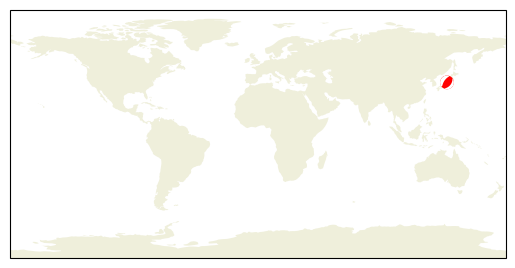

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
# ax.set_extent([60, 250, -40, 80])
ax.set_global()
ax.add_feature(cfeature.LAND)
# ax.coastlines()
bb = beach(mt, xy=(origin.longitude, origin.latitude), facecolor='red', edgecolor='none', width=10)
ax.add_collection(bb)


In [5]:
sta_name = "TARA"

In [6]:
inv = obspy.read_inventory(f"./data/C202401010710A/stations/*.{sta_name}.xml")
tr_obsd = obspy.read(f"./data/C202401010710A/waveforms/*{sta_name}*BHZ*mseed")[0]
tr_synt = obspy.read(f"./new_data/*{sta_name}*MXZ*sac")[0]

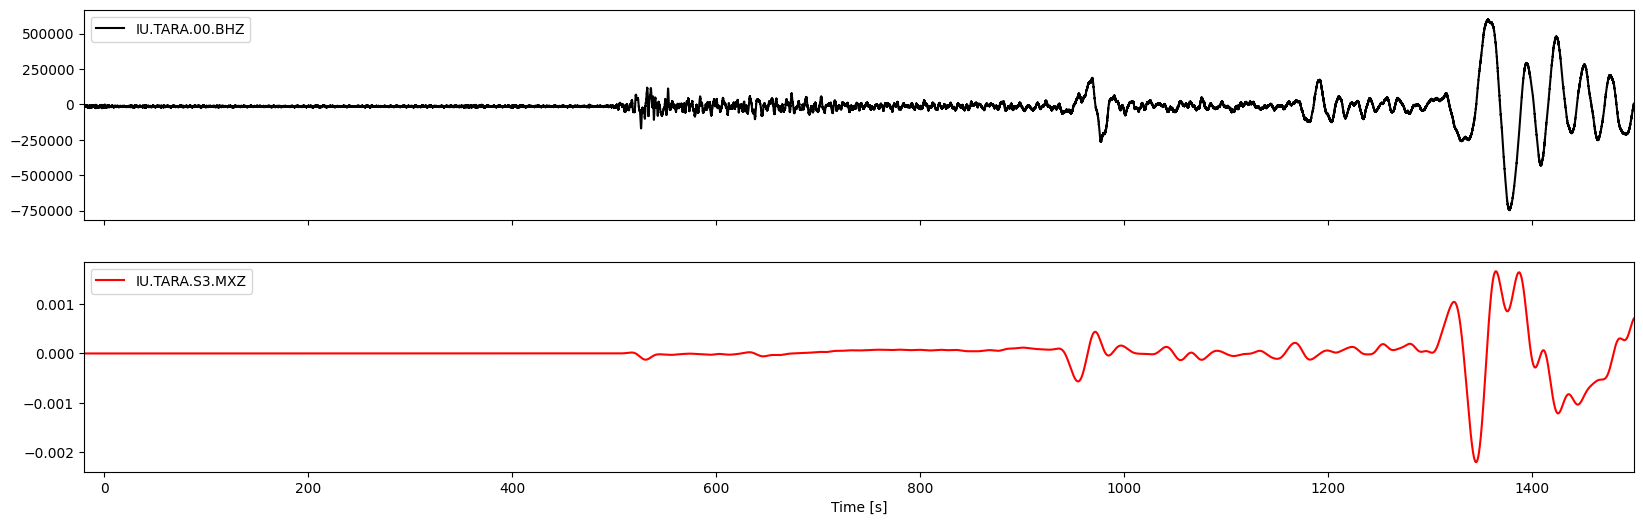

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 6), sharex=True)
ax = axes[0]
ax.plot(tr_obsd.times(reftime=origin.time), tr_obsd.data, "k", label=tr_obsd.id)
ax.legend()

ax = axes[1]
ax.plot(tr_synt.times(reftime=origin.time), tr_synt.data, "r", label=tr_synt.id)
ax.set_xlim(-20, 25*60)
ax.legend()
ax.set_xlabel("Time [s]");

In [8]:
sampling_rate = tr_synt.stats.sampling_rate
starttime = origin.time
npts = int(sampling_rate*25*60)
# starttime = tr_synt.stats.starttime
# npts = tr_synt.stats.npts
synt_starttime = tr_synt.stats.starttime
synt_npts = tr_synt.stats.npts
synt_deltat = tr_synt.stats.delta

## Cut and Resample

In [9]:
tr_obsd.interpolate(sampling_rate, starttime=starttime, npts=npts)

IU.TARA.00.BHZ | 2024-01-01T07:10:39.140000Z - 2024-01-01T07:35:38.960014Z | 7.1 Hz, 10714 samples

In [10]:
tr_synt.interpolate(sampling_rate, starttime=starttime, npts=npts)

IU.TARA.S3.MXZ | 2024-01-01T07:10:39.140000Z - 2024-01-01T07:35:38.960014Z | 7.1 Hz, 10714 samples

## Remove response and filter

IU.TARA.00.BHZ | 2024-01-01T07:10:39.140000Z - 2024-01-01T07:35:38.960014Z | 7.1 Hz, 10714 samples

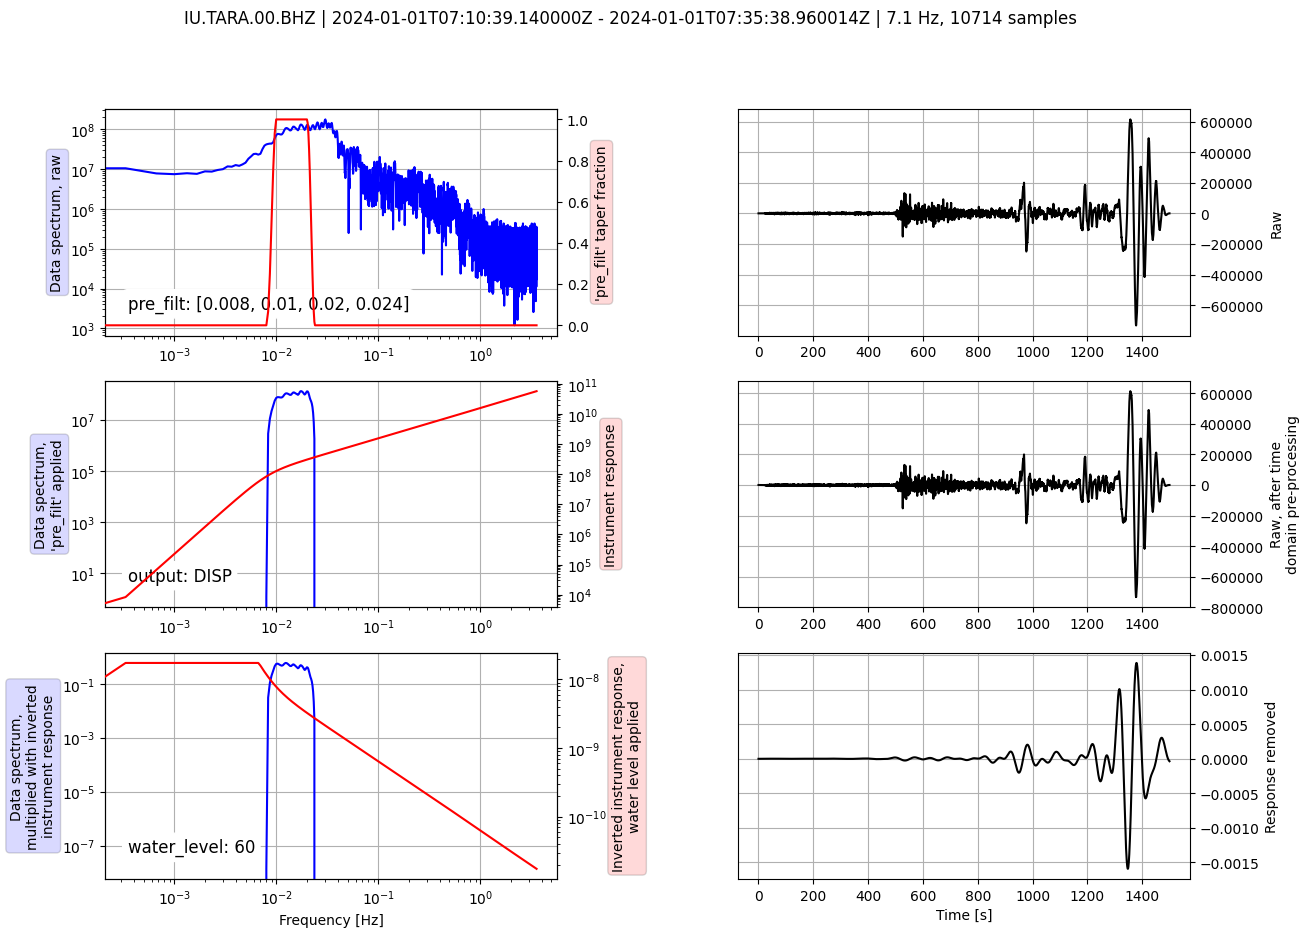

In [11]:
tr_obsd.detrend("linear")
tr_obsd.detrend("demean")
tr_obsd.taper(0.05)


min_period = 50
max_period = 100
freqmin = 1.0/max_period
freqmax = 1.0/min_period
pre_filt = (0.8*freqmin, freqmin, freqmax, 1.2*freqmax)

tr_obsd.attach_response(inv)
tr_obsd.remove_response(output="DISP", pre_filt=pre_filt, water_level=60, plot=True)

In [12]:
def sac_taper(tr):
    data = tr.data.astype(np.float64)
    nfft = _npts2nfft(len(tr.data))
    data = np.fft.rfft(tr.data, nfft)
    fy = 1.0 / (tr.stats.delta * 2.0)
    freqs = np.linspace(0, fy, nfft//2+1)
    data *= cosine_sac_taper(freqs, flimit=pre_filt)
    data[-1] = abs(data[-1]) + 0.0j
    tr.data = np.fft.irfft(data)[0:len(tr.data)]

tr_synt.detrend("linear")
tr_synt.detrend("demean")
tr_synt.taper(0.05)
sac_taper(tr_synt)

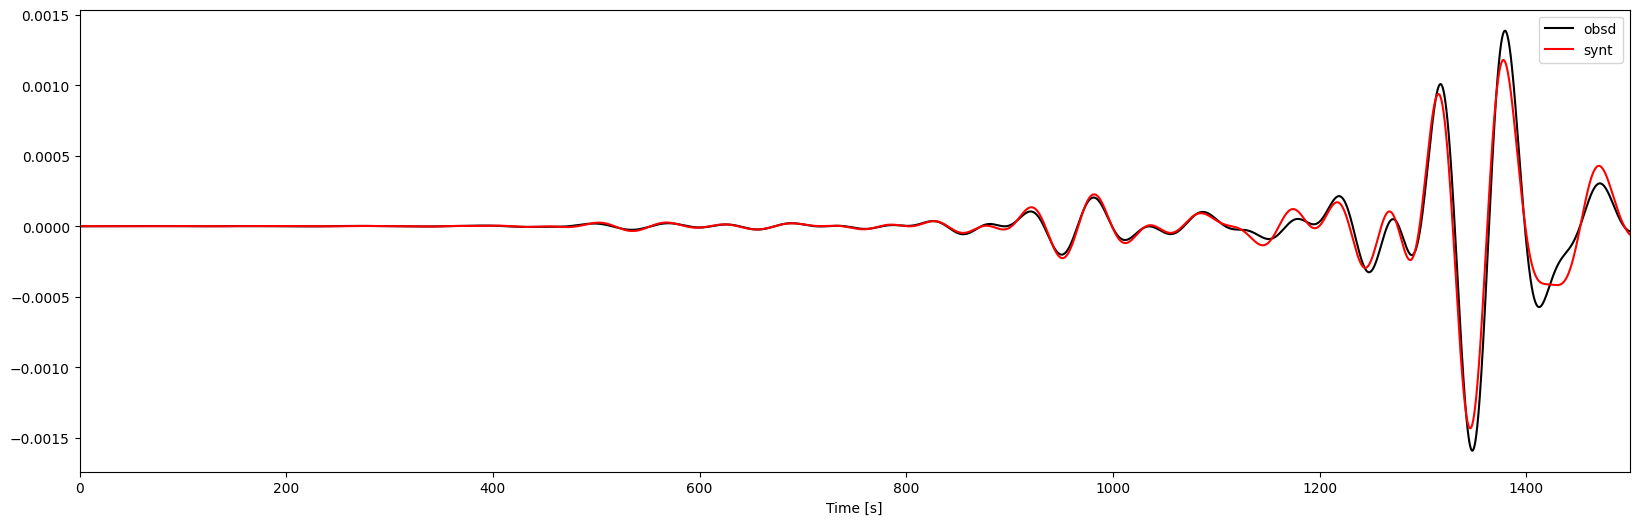

In [13]:
fig, axes = plt.subplots(nrows=1, figsize=(20, 6), sharex=True)
ax = axes
ax.plot(tr_obsd.times(reftime=origin.time), tr_obsd.data, "k", label="obsd")
ax.legend()

# ax = axes[1]
ax.plot(tr_synt.times(reftime=origin.time), tr_synt.data, "r", label="synt")
ax.set_xlim(0, 25*60)
ax.legend()
ax.set_xlabel("Time [s]");

In [14]:
sta_coords = inv.get_coordinates(tr_obsd.id)

In [15]:
model = TauPyModel("iasp91")
tt = model.get_travel_times_geo(origin.depth/1000,
                               origin.latitude, origin.longitude,
                               sta_coords["latitude"], sta_coords["longitude"], phase_list=["P"])
print(tt)

1 arrivals
	P phase arrival at 525.133 seconds


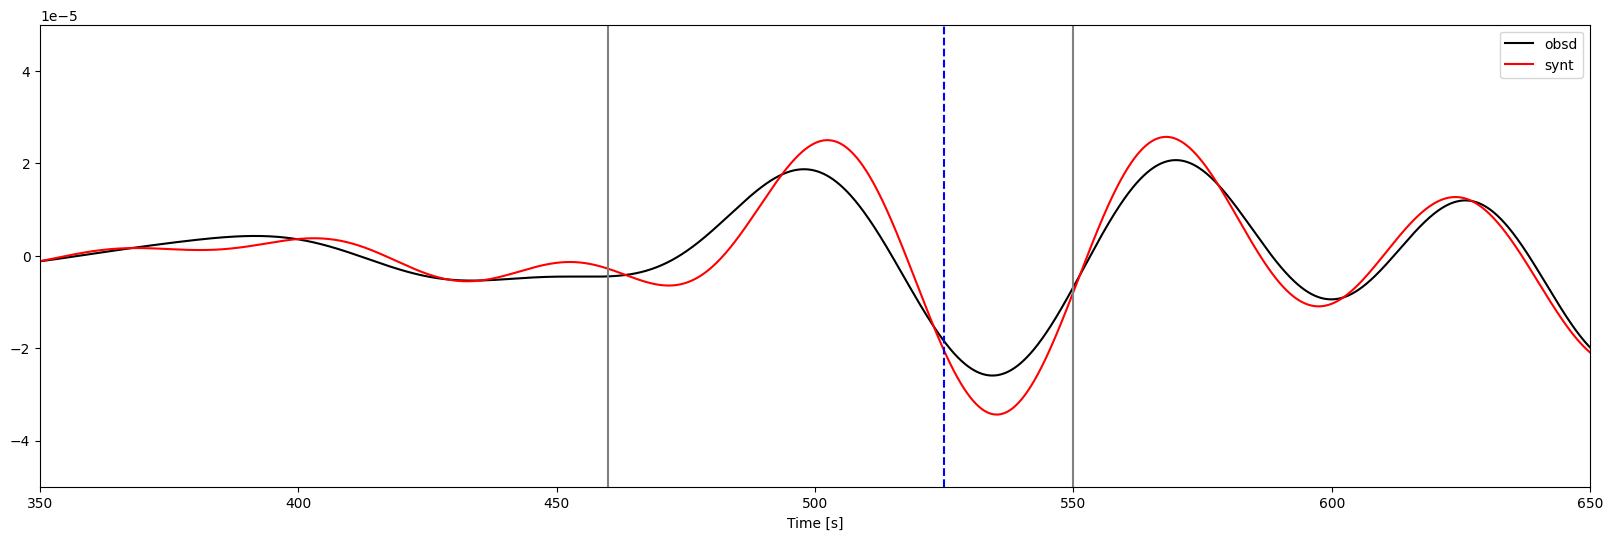

In [16]:
fig, ax = plt.subplots(nrows=1, figsize=(20, 6), sharex=True)
ax.plot(tr_obsd.times(reftime=origin.time), tr_obsd.data, "k", label="obsd")
# ax = axes[1]
ax.plot(tr_synt.times(reftime=origin.time), tr_synt.data, "r", label="synt")
ax.set_xlim(350, 650)
ax.set_ylim(-5e-5, 5e-5)
ax.axvline(525, linestyle="--", color="b")

window = [460, 550]
ax.axvline(window[0], color="gray")
ax.axvline(window[1], color="gray")

ax.legend()
ax.set_xlabel("Time [s]");

### Traveltime
Misfit function
$$
\chi = \frac{1}{2} \sum_{i=0}^{N_r} [T^{obs}_{i} - T^{syn}_{i}]^2
$$
Adjoint source for i-th station
$$
f^{\dagger}_i(t) = - \frac{1}{N} ~ \left[ T^{obs}_{i} - T^{syn}_{i} \right] ~ 
\partial_t s_i(t,m),
$$

where 
$$
N = \int_0^T ~ s_i(t,m) ~
\partial^2_t s_i(t,m) dt.
$$

In [17]:
def zero_pad(tr, starttime, npts, dynamic_npts=0):
    delta = tr.stats.delta
    cut_starttime = starttime - dynamic_npts * delta
    cut_endtime = starttime + npts*delta + dynamic_npts * delta
    print(cut_starttime, cut_endtime)
    tr.trim(cut_starttime, cut_endtime, pad=True, fill_value=0.0)

-2.5200000240325933
IU.TARA.S3.MXZ | 2024-01-01T07:10:39.140000Z - 2024-01-01T07:35:38.960014Z | 7.1 Hz, 10714 samples
2024-01-01T07:10:17.840001Z 2024-01-01T07:36:25.840016Z
IU.TARA.S3.MXZ | 2024-01-01T07:10:17.860000Z - 2024-01-01T07:36:25.860015Z | 7.1 Hz, 11201 samples


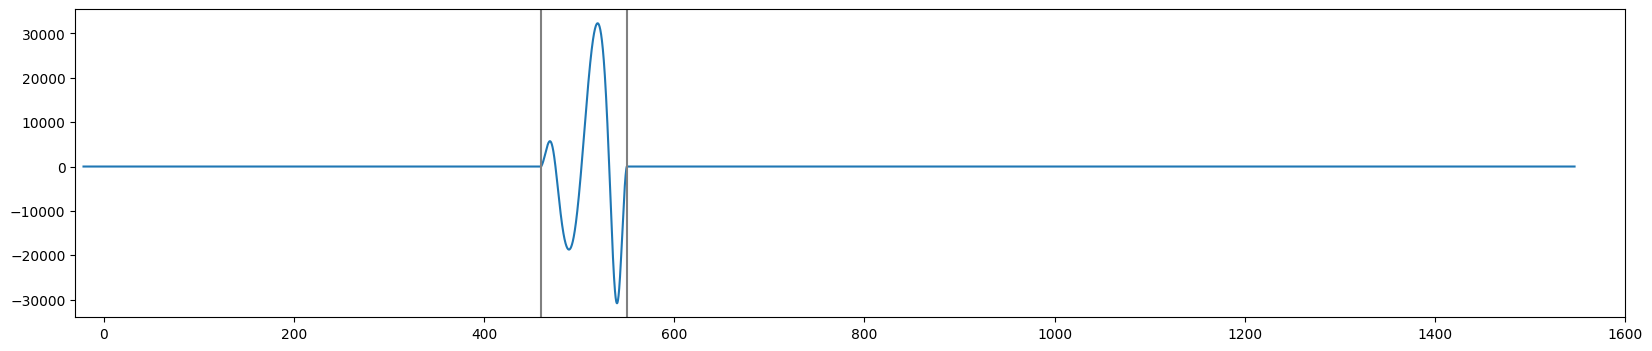

In [18]:
def xcorr_shift(d, s):
    cc = np.correlate(d, s, mode="full")
    time_shift = cc.argmax() - len(d) + 1
    return time_shift

def window_taper(signal, taper_percentage=1.0):
    npts = len(signal)
    if taper_percentage == 0.0 or taper_percentage == 1.0:
        frac = int(npts*taper_percentage / 2.0)
    else:
        frac = int(npts*taper_percentage / 2.0 + 0.5)

    idx1 = frac
    idx2 = npts - frac

    power = 10.
    signal[:idx1] *= 1. - np.cos(np.pi * np.arange(0, frac) /
                                 (2 * frac - 1)) ** power
    signal[idx2:] *= 1. - np.cos(np.pi * np.arange(frac, 2 * frac) /
                                 (2 * frac - 1)) ** power

def calc_traveltime_adjoint_source(tr_obsd, tr_synt, window, taper_percentage=1.0):
    if tr_obsd.stats.npts != tr_synt.stats.npts:
        print(f"Observed and synthetic data have different data length: {tr_obsd.stats.npts} and {tr_synt.stats.npts}")
        return None

    if tr_obsd.stats.sampling_rate != tr_synt.stats.sampling_rate:
        print(f"Observed and synthetic data have different sampling rate: {tr_obsd.stats.sampling_rate} and {tr_synt.stats.sampling_rate}")
        return None

    deltat = tr_synt.stats.delta
    adjoint_source = tr_synt.copy()
    adjoint_source.data = np.zeros_like(tr_synt.data)

    left_window_border, right_window_border = window
    left_sample = int(np.floor(left_window_border / deltat)) + 1
    nlen = int(np.floor((right_window_border -
                        left_window_border) / deltat)) + 1
    right_sample = left_sample + nlen

    d = np.zeros(nlen)
    s = np.zeros(nlen)

    d[0:nlen] = tr_obsd.data[left_sample:right_sample]
    s[0:nlen] = tr_synt.data[left_sample:right_sample]

    window_taper(d, taper_percentage=taper_percentage)
    window_taper(s, taper_percentage=taper_percentage)

    ishift = xcorr_shift(d, s)
    tshift = ishift * deltat

    misfit = 0.5 * tshift**2

    # derivative of synthetic
    dt_s = np.gradient(s, deltat)
    norm = simpson(y=dt_s*dt_s, dx=deltat)
    # dt2_s = np.gradient(dt_s, deltat)
    # norm2 = simpson(s*dt2_s, dx=deltat)
    
    adjoint_source.data[left_sample:right_sample] = tshift * dt_s / norm
    # adjoint_source2[left_sample:right_sample] = - tshift * dt_s / norm2
    
    
    print(tshift)
    return adjoint_source

b = int((origin.time - tr_synt.stats.starttime))
adj = calc_traveltime_adjoint_source(tr_obsd, tr_synt, window)
print(adj)
zero_pad(adj, synt_starttime, synt_npts)
adj.trim(starttime=synt_starttime, endtime=synt_starttime+synt_npts*synt_deltat, fill_value=0, pad=True)
print(adj)

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(adj.times(reftime=origin.time), adj)

ax.axvline(window[0], color="gray")
ax.axvline(window[1], color="gray")
ax.set_xlim(-30, 1600)

# adj.interpolate(

with open("adj.txt", "w") as f:
    times = adj.times(reftime=origin.time)
    for t, a in zip(times[:synt_npts], adj):
        f.write(f"{t:.10f} {a:.10f}\n")